## DW #2 

### Contexte et setup (imports, reproductibilité)

In [18]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from pathlib import Path
import matplotlib.pyplot as plt

rng = np.random.default_rng(7)

data_root = Path("../data")
for sub in ["raw", "staging", "dim", "fact", "output"]:
    (data_root / sub).mkdir(parents=True, exist_ok=True)

start, end = datetime(2025, 1, 1), datetime(2025, 9, 30)
dates = pd.date_range(start, end, freq="D")

print("dates:", dates.min(), "→", dates.max())
print("nombre de jours:", len(dates))


dates: 2025-01-01 00:00:00 → 2025-09-30 00:00:00
nombre de jours: 273


### Génération RAW : référentiels (machines, produits, shifts)

In [19]:
areas = ["Cutting", "Assembly", "Packaging"]

raw_machines = pd.DataFrame({
    "machine_id": range(1, 16),
    "machine_name": [f"M{i:02d}" for i in range(1, 16)],
    "area": np.random.choice(areas, 15),
    "install_date": pd.to_datetime("2022-01-01") + pd.to_timedelta(
        rng.integers(0, 365, 15), unit="D"
    )
})

raw_products = pd.DataFrame({
    "sku": [f"SKU{i:03d}" for i in range(1, 41)],
    "product_name": [f"Prod {i:03d}" for i in range(1, 41)],
    "ideal_rate_per_min": rng.choice([0.8, 1.0, 1.2, 1.5], 40)
})

raw_shifts = pd.DataFrame({
    "shift_id": [1, 2, 3],
    "shift_name": ["Shift A", "Shift B", "Shift C"],
    "planned_minutes": [480, 480, 480]
})

print("raw_machines.head():")
print(raw_machines.head(), "\n")
print("raw_products.head():")
print(raw_products.head(), "\n")
print("raw_shifts.head():")
print(raw_shifts.head(), "\n")



raw_machines.head():
   machine_id machine_name       area install_date
0           1          M01  Packaging   2022-12-11
1           2          M02    Cutting   2022-08-17
2           3          M03    Cutting   2022-09-07
3           4          M04  Packaging   2022-11-24
4           5          M05   Assembly   2022-07-31 

raw_products.head():
      sku product_name  ideal_rate_per_min
0  SKU001     Prod 001                 1.5
1  SKU002     Prod 002                 0.8
2  SKU003     Prod 003                 1.5
3  SKU004     Prod 004                 0.8
4  SKU005     Prod 005                 1.0 

raw_shifts.head():
   shift_id shift_name  planned_minutes
0         1    Shift A              480
1         2    Shift B              480
2         3    Shift C              480 



### Génération RAW : production et arrêts (downtime)

In [20]:
prod_rows = []
for d in dates:
    for m in raw_machines["machine_id"]:
        for s in raw_shifts["shift_id"]:
            if rng.random() < 0.85:
                sku = rng.choice(raw_products["sku"])
                good = rng.integers(200, 800)
                scrap = rng.integers(0, int(good * 0.15))
                prod_rows.append([d, m, s, sku, good, scrap])

raw_production = pd.DataFrame(
    prod_rows,
    columns=["prod_date", "machine_id", "shift_id", "sku", "units_good", "units_scrap"]
)
print("raw_production.shape:", raw_production.shape)
print(raw_production.head(), "\n")

failure_modes = ["Setup", "Breakdown", "Quality", "Material", "PlannedMaintenance"]

down_rows = []
for d in dates:
    for m in raw_machines["machine_id"]:
        k = rng.integers(0, 3)
        for _ in range(k):
            minutes = rng.integers(10, 90)
            fm = rng.choice(failure_modes, p=[0.25, 0.35, 0.15, 0.15, 0.10])
            down_rows.append([d, m, fm, minutes])

raw_downtime = pd.DataFrame(
    down_rows,
    columns=["down_date", "machine_id", "failure_mode", "minutes_down"]
)
print("raw_downtime.shape:", raw_downtime.shape)
print(raw_downtime.head(), "\n")

raw_path = data_root / "raw"
raw_machines.to_csv(raw_path / "raw_machines.csv", index=False)
raw_products.to_csv(raw_path / "raw_products.csv", index=False)
raw_shifts.to_csv(raw_path / "raw_shifts.csv", index=False)
raw_production.to_csv(raw_path / "raw_production.csv", index=False)
raw_downtime.to_csv(raw_path / "raw_downtime.csv", index=False)
print("RAW CSV enregistrés dans:", raw_path.resolve())



raw_production.shape: (10380, 6)
   prod_date  machine_id  shift_id     sku  units_good  units_scrap
0 2025-01-01           1         1  SKU037         464           35
1 2025-01-01           1         2  SKU016         348           51
2 2025-01-01           1         3  SKU001         781           80
3 2025-01-01           2         1  SKU029         421           30
4 2025-01-01           2         2  SKU001         598           13 

raw_downtime.shape: (4217, 4)
   down_date  machine_id failure_mode  minutes_down
0 2025-01-01           1        Setup            25
1 2025-01-01           1    Breakdown            25
2 2025-01-01           3        Setup            51
3 2025-01-01           4    Breakdown            22
4 2025-01-01           4     Material            72 

RAW CSV enregistrés dans: C:\Users\24160\Desktop\TP\data\raw


### Staging : nettoyage standardisation

In [21]:
stg_machines = raw_machines.assign(
    machine_name = raw_machines["machine_name"].str.upper(),
    area = raw_machines["area"].str.title()
)

stg_products = raw_products.assign(
    product_name = raw_products["product_name"].str.title()
)

stg_shifts = raw_shifts.copy()

stg_production = raw_production.assign(
    prod_date = pd.to_datetime(raw_production["prod_date"]),
    units_total = lambda df: df["units_good"] + df["units_scrap"]
)

stg_downtime = raw_downtime.assign(
    down_date = pd.to_datetime(raw_downtime["down_date"]),
    failure_mode = raw_downtime["failure_mode"].str.replace("_", " ").str.title()
)

print("stg_machines.head():")
print(stg_machines.head(), "\n")
print("stg_products.head():")
print(stg_products.head(), "\n")
print("stg_production.head():")
print(stg_production.head(), "\n")
print("stg_downtime.head():")
print(stg_downtime.head(), "\n")

# 保存 STAGING
stg_path = data_root / "staging"
stg_machines.to_csv(stg_path / "stg_machines.csv", index=False)
stg_products.to_csv(stg_path / "stg_products.csv", index=False)
stg_shifts.to_csv(stg_path / "stg_shifts.csv", index=False)
stg_production.to_csv(stg_path / "stg_production.csv", index=False)
stg_downtime.to_csv(stg_path / "stg_downtime.csv", index=False)
print("STAGING CSV enregistrés dans:", stg_path.resolve())


stg_machines.head():
   machine_id machine_name       area install_date
0           1          M01  Packaging   2022-12-11
1           2          M02    Cutting   2022-08-17
2           3          M03    Cutting   2022-09-07
3           4          M04  Packaging   2022-11-24
4           5          M05   Assembly   2022-07-31 

stg_products.head():
      sku product_name  ideal_rate_per_min
0  SKU001     Prod 001                 1.5
1  SKU002     Prod 002                 0.8
2  SKU003     Prod 003                 1.5
3  SKU004     Prod 004                 0.8
4  SKU005     Prod 005                 1.0 

stg_production.head():
   prod_date  machine_id  shift_id     sku  units_good  units_scrap  \
0 2025-01-01           1         1  SKU037         464           35   
1 2025-01-01           1         2  SKU016         348           51   
2 2025-01-01           1         3  SKU001         781           80   
3 2025-01-01           2         1  SKU029         421           30   
4 2025-01-01

### Dimensions : dim_date, dim_machine, dim_product,dim_shift

In [22]:
dim_date = pd.DataFrame({
    "date": pd.date_range(
        stg_production["prod_date"].min(),
        stg_production["prod_date"].max(),
        freq="D"
    )
})
dim_date["date_sk"] = np.arange(1, len(dim_date) + 1)
dim_date = dim_date.assign(
    day = dim_date["date"].dt.day,
    month = dim_date["date"].dt.month,
    quarter = dim_date["date"].dt.quarter,
    year = dim_date["date"].dt.year,
    dow = dim_date["date"].dt.dayofweek
)

dim_machine = stg_machines.drop_duplicates("machine_id").reset_index(drop=True)
dim_machine["machine_sk"] = np.arange(1, len(dim_machine) + 1)

dim_product = stg_products.drop_duplicates("sku").reset_index(drop=True)
dim_product["product_sk"] = np.arange(1, len(dim_product) + 1)

dim_shift = stg_shifts.copy()
dim_shift["shift_sk"] = dim_shift["shift_id"]

print("dim_date.head():")
print(dim_date.head(), "\n")
print("dim_machine.head():")
print(dim_machine.head(), "\n")
print("dim_product.head():")
print(dim_product.head(), "\n")
print("dim_shift.head():")
print(dim_shift.head(), "\n")

# 保存 DIM
dim_path = data_root / "dim"
dim_date.to_csv(dim_path / "dim_date.csv", index=False)
dim_machine.to_csv(dim_path / "dim_machine.csv", index=False)
dim_product.to_csv(dim_path / "dim_product.csv", index=False)
dim_shift.to_csv(dim_path / "dim_shift.csv", index=False)
print("Dimensions CSV enregistrés dans:", dim_path.resolve())



dim_date.head():
        date  date_sk  day  month  quarter  year  dow
0 2025-01-01        1    1      1        1  2025    2
1 2025-01-02        2    2      1        1  2025    3
2 2025-01-03        3    3      1        1  2025    4
3 2025-01-04        4    4      1        1  2025    5
4 2025-01-05        5    5      1        1  2025    6 

dim_machine.head():
   machine_id machine_name       area install_date  machine_sk
0           1          M01  Packaging   2022-12-11           1
1           2          M02    Cutting   2022-08-17           2
2           3          M03    Cutting   2022-09-07           3
3           4          M04  Packaging   2022-11-24           4
4           5          M05   Assembly   2022-07-31           5 

dim_product.head():
      sku product_name  ideal_rate_per_min  product_sk
0  SKU001     Prod 001                 1.5           1
1  SKU002     Prod 002                 0.8           2
2  SKU003     Prod 003                 1.5           3
3  SKU004     Pro

### Tables de faits : production + downtime

In [23]:
prod = (
    stg_production
    .merge(dim_date[["date", "date_sk"]], left_on="prod_date", right_on="date")
    .drop(columns=["date"])
    .merge(dim_machine[["machine_id", "machine_sk"]], on="machine_id")
    .merge(dim_product[["sku", "product_sk", "ideal_rate_per_min"]], on="sku")
    .merge(dim_shift[["shift_id", "shift_sk", "planned_minutes"]], on="shift_id")
)

fact_production = prod[[
    "date_sk", "machine_sk", "shift_sk", "product_sk",
    "units_good", "units_scrap", "units_total",
    "ideal_rate_per_min", "planned_minutes"
]]
print("fact_production.head():")
print(fact_production.head(), "\n")

down = (
    stg_downtime
    .merge(dim_date[["date", "date_sk"]], left_on="down_date", right_on="date")
    .drop(columns=["date"])
    .merge(dim_machine[["machine_id", "machine_sk"]], on="machine_id")
)

fact_downtime = down[["date_sk", "machine_sk", "failure_mode", "minutes_down"]]
print("fact_downtime.head():")
print(fact_downtime.head(), "\n")

fact_path = data_root / "fact"
fact_production.to_csv(fact_path / "fact_production.csv", index=False)
fact_downtime.to_csv(fact_path / "fact_downtime.csv", index=False)
print("Faits CSV enregistrés dans:", fact_path.resolve())


fact_production.head():
   date_sk  machine_sk  shift_sk  product_sk  units_good  units_scrap  \
0        1           1         1          37         464           35   
1        1           1         2          16         348           51   
2        1           1         3           1         781           80   
3        1           2         1          29         421           30   
4        1           2         2           1         598           13   

   units_total  ideal_rate_per_min  planned_minutes  
0          499                 1.2              480  
1          399                 1.2              480  
2          861                 1.5              480  
3          451                 0.8              480  
4          611                 1.5              480   

fact_downtime.head():
   date_sk  machine_sk failure_mode  minutes_down
0        1           1        Setup            25
1        1           1    Breakdown            25
2        1           3        Setup    

### Agrégations / OEE + Graphique

oee_month.head():
   year  month       oee
0  2025      1  0.872958
1  2025      2  0.867475
2  2025      3  0.877200
3  2025      4  0.872956
4  2025      5  0.873211 



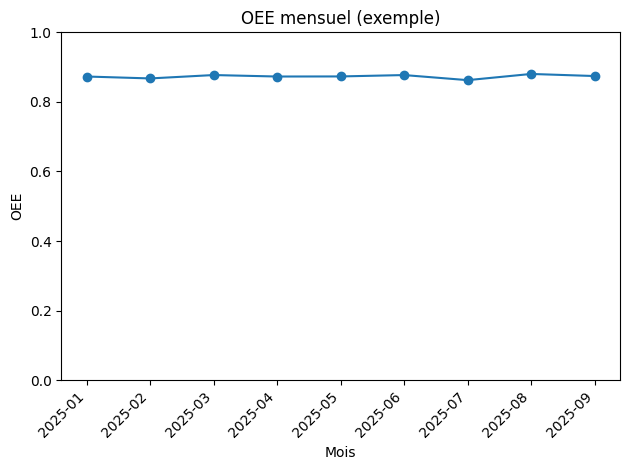

Graphique enregistré dans: C:\Users\24160\Desktop\TP\data\output


In [24]:
daily_prod = (
    fact_production
    .merge(dim_date[["date_sk", "year", "month", "date"]], on="date_sk")
    .groupby(["date", "year", "month"], as_index=False)
    .agg(
        units_good=("units_good", "sum"),
        units_total=("units_total", "sum"),
        planned_minutes=("planned_minutes", "sum"),
        ideal_rate=("ideal_rate_per_min", "mean")  
    )
)

daily_down = (
    fact_downtime
    .merge(dim_date[["date_sk", "date"]], on="date_sk")
    .groupby("date", as_index=False)["minutes_down"].sum()
)

daily = daily_prod.merge(daily_down, on="date", how="left").fillna({"minutes_down": 0})

daily["availability"] = (
    (daily["planned_minutes"] - daily["minutes_down"]) / daily["planned_minutes"]
)
runtime = (daily["planned_minutes"] - daily["minutes_down"]).clip(lower=1)
daily["performance"] = (
    (daily["units_total"] / (daily["ideal_rate"] * runtime)).clip(upper=1)
)
daily["quality"] = (
    (daily["units_good"] / daily["units_total"]).replace([np.inf, np.nan], 0)
)
daily["oee"] = (
    (daily["availability"] * daily["performance"] * daily["quality"]).fillna(0)
)

oee_month = (
    daily.groupby(["year", "month"], as_index=False)
    .agg(oee=("oee", "mean"))
)

print("oee_month.head():")
print(oee_month.head(), "\n")

x = range(len(oee_month))
labels = [f"{int(y)}-{int(m):02d}" for y, m in zip(oee_month["year"], oee_month["month"])]

plt.figure()
plt.plot(x, oee_month["oee"], marker="o")
plt.title("OEE mensuel (exemple)")
plt.xlabel("Mois")
plt.ylabel("OEE")
plt.ylim(0, 1)
plt.xticks(x, labels, rotation=45, ha="right")
plt.tight_layout()

output_path = data_root / "output"
plt.savefig(output_path / "monthly_oee.png")
plt.show()
print("Graphique enregistré dans:", output_path.resolve())


### TP : exercices proposés

##### 1. Calculer l’OEE par machine et par zone (area). Identifier les 5 machines les moins performantes

In [25]:
prod_j = fact_production.merge(dim_machine[["machine_sk", "machine_name", "area"]], on="machine_sk")
down_j = fact_downtime.merge(dim_machine[["machine_sk", "machine_name", "area"]], on="machine_sk")


down_m = down_j.groupby("machine_sk", as_index=False)["minutes_down"].sum()

df = prod_j.merge(down_m, on="machine_sk", how="left").fillna({"minutes_down": 0})

agg_m = (df.groupby(["machine_sk", "machine_name", "area"], as_index=False)
         .agg(units_good=("units_good", "sum"),
              units_total=("units_total", "sum"),
              planned_minutes=("planned_minutes", "sum"),
              ideal_rate=("ideal_rate_per_min", "mean"),
              minutes_down=("minutes_down", "sum")))

agg_m["dispo"] = (agg_m["planned_minutes"] - agg_m["minutes_down"]) / agg_m["planned_minutes"]
runtime = (agg_m["planned_minutes"] - agg_m["minutes_down"]).clip(lower=1)
agg_m["perf"] = (agg_m["units_total"] / (agg_m["ideal_rate"] * runtime)).clip(upper=1)
agg_m["qual"] = (agg_m["units_good"] / agg_m["units_total"]).replace([np.inf, np.nan], 0)
agg_m["oee"] = (agg_m["dispo"] * agg_m["perf"] * agg_m["qual"]).fillna(0)

print("Aperçu du calcul OEE par machine :")
print(agg_m[["machine_name", "area", "dispo", "perf", "qual", "oee"]].head(), "\n")

agg_zone = (agg_m.groupby("area", as_index=False)
            .agg(oee_moy=("oee", "mean"),
                 dispo_moy=("dispo", "mean"),
                 perf_moy=("perf", "mean"),
                 qual_moy=("qual", "mean"))
            .sort_values("oee_moy", ascending=False))

print("OEE moyen par zone :")
print(agg_zone, "\n")

top5 = agg_m.sort_values("oee", ascending=True).head(5)
print("Les 5 machines les moins performantes :")
print(top5[["machine_name", "area", "oee"]])


Aperçu du calcul OEE par machine :
  machine_name       area      dispo  perf      qual        oee
0          M01  Packaging -27.687500   1.0  0.931965 -25.803775
1          M02    Cutting -25.166667   1.0  0.930534 -23.418427
2          M03    Cutting -26.468750   1.0  0.932335 -24.677754
3          M04  Packaging -28.987500   1.0  0.931500 -27.001845
4          M05   Assembly -32.872917   1.0  0.931946 -30.635783 

OEE moyen par zone :
        area    oee_moy  dispo_moy  perf_moy  qual_moy
1    Cutting -24.130685 -25.907292       1.0  0.931428
2  Packaging -26.202728 -28.135417       1.0  0.931306
0   Assembly -27.498954 -29.531771       1.0  0.931146 

Les 5 machines les moins performantes :
   machine_name       area        oee
4           M05   Assembly -30.635783
11          M12  Packaging -28.208787
7           M08  Packaging -27.823663
6           M07   Assembly -27.740620
3           M04  Packaging -27.001845


##### 2. Décomposer l’OEE en A/P/Q par mois et tracer 3 courbes.

In [26]:
dfj = fact_production.merge(dim_date[["date_sk", "year", "month", "date"]], on="date_sk")

mensuel = (
    dfj.groupby(["year", "month"], as_index=False)
    .agg(
        units_good=("units_good", "sum"),
        units_total=("units_total", "sum"),
        planned_minutes=("planned_minutes", "sum"),
        ideal_rate=("ideal_rate_per_min", "mean")
    )
)

down_mensuel = (
    fact_downtime.merge(dim_date[["date_sk", "year", "month"]], on="date_sk")
    .groupby(["year", "month"], as_index=False)["minutes_down"]
    .sum()
)

mensuel = mensuel.merge(down_mensuel, on=["year", "month"], how="left").fillna({"minutes_down": 0})

mensuel["A"] = (mensuel["planned_minutes"] - mensuel["minutes_down"]) / mensuel["planned_minutes"]
runtime = (mensuel["planned_minutes"] - mensuel["minutes_down"]).clip(lower=1)
mensuel["P"] = (mensuel["units_total"] / (mensuel["ideal_rate"] * runtime)).clip(upper=1)
mensuel["Q"] = (mensuel["units_good"] / mensuel["units_total"]).replace([np.inf, np.nan], 0)
mensuel["OEE"] = (mensuel["A"] * mensuel["P"] * mensuel["Q"]).fillna(0)

print("Aperçu du calcul mensuel :")
print(mensuel[["year", "month", "A", "P", "Q", "OEE"]].head())


Aperçu du calcul mensuel :
   year  month         A    P         Q       OEE
0  2025      1  0.956958  1.0  0.931821  0.891714
1  2025      2  0.955254  1.0  0.932273  0.890557
2  2025      3  0.960046  1.0  0.930437  0.893262
3  2025      4  0.957262  1.0  0.929827  0.890088
4  2025      5  0.959492  1.0  0.930845  0.893138


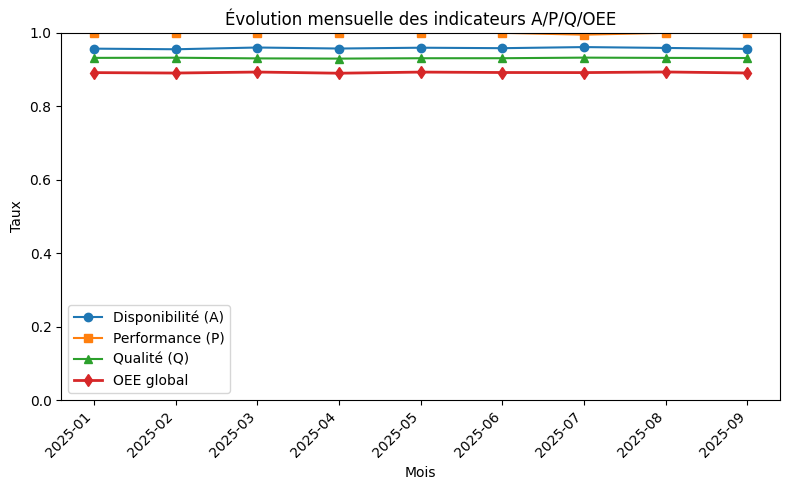

Graphique enregistré dans: C:\Users\24160\Desktop\TP\data\output\oee_apq_mensuel.png


In [27]:
x = range(len(mensuel))
labels = [f"{int(y)}-{int(m):02d}" for y, m in zip(mensuel["year"], mensuel["month"])]

plt.figure(figsize=(8,5))
plt.plot(x, mensuel["A"], marker="o", label="Disponibilité (A)")
plt.plot(x, mensuel["P"], marker="s", label="Performance (P)")
plt.plot(x, mensuel["Q"], marker="^", label="Qualité (Q)")
plt.plot(x, mensuel["OEE"], marker="d", label="OEE global", linewidth=2)

plt.title("Évolution mensuelle des indicateurs A/P/Q/OEE")
plt.xlabel("Mois")
plt.ylabel("Taux")
plt.ylim(0, 1)
plt.xticks(x, labels, rotation=45, ha="right")
plt.legend()
plt.tight_layout()

out = data_root / "output" / "oee_apq_mensuel.png"
plt.savefig(out)
plt.show()
print("Graphique enregistré dans:", out.resolve())


##### 3. Top 10 modes de défaillance par minutes perdues ; Pareto 80/20

Top 10 modes de défaillance par minutes perdues :
         failure_mode  minutes_down        pct     pct_cum
0           Breakdown         73208  35.166060   35.166060
4               Setup         50552  24.283065   59.449125
3             Quality         32017  15.379627   74.828752
1            Material         30854  14.820971   89.649723
2  Plannedmaintenance         21547  10.350277  100.000000 



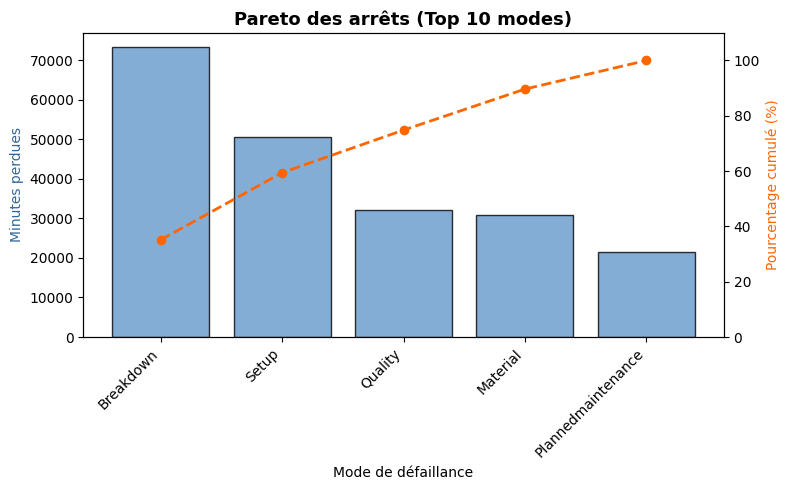

Graphique Pareto coloré enregistré dans : C:\Users\24160\Desktop\TP\data\output\pareto_downtime_color.png


In [30]:
df_pareto = (
    fact_downtime
    .groupby("failure_mode", as_index=False)["minutes_down"]
    .sum()
    .sort_values("minutes_down", ascending=False)
)

total = df_pareto["minutes_down"].sum()
df_pareto["pct"] = df_pareto["minutes_down"] / total * 100
df_pareto["pct_cum"] = df_pareto["pct"].cumsum()

top10 = df_pareto.head(10)

print("Top 10 modes de défaillance par minutes perdues :")
print(top10, "\n")

fig, ax1 = plt.subplots(figsize=(8,5))

ax1.bar(top10["failure_mode"], top10["minutes_down"], color="#6699CC", edgecolor="black", alpha=0.8)
ax1.set_xlabel("Mode de défaillance")
ax1.set_ylabel("Minutes perdues", color="#336699")
plt.xticks(rotation=45, ha="right")

ax2 = ax1.twinx()
ax2.plot(top10["failure_mode"], top10["pct_cum"], color="#FF6600", marker="o", linestyle="--", linewidth=2)
ax2.set_ylabel("Pourcentage cumulé (%)", color="#FF6600")
ax2.set_ylim(0, 110)

plt.title("Pareto des arrêts (Top 10 modes)", fontsize=13, fontweight="bold")
plt.tight_layout()

out = data_root / "output" / "pareto_downtime_color.png"
plt.savefig(out)
plt.show()
print("Graphique Pareto coloré enregistré dans :", out.resolve())



##### 4. Construire une vue matérialisée v_oee_monthly(area).

In [ ]:
prod_a = fact_production.merge(dim_machine[["machine_sk", "area"]], on="machine_sk")
prod_a = prod_a.merge(dim_date[["date_sk", "year", "month"]], on="date_sk")
down_a = fact_downtime.merge(dim_machine[["machine_sk", "area"]], on="machine_sk")
down_a = down_a.merge(dim_date[["date_sk", "year", "month"]], on="date_sk")

down_mois = (
    down_a.groupby(["area", "year", "month"], as_index=False)["minutes_down"]
    .sum()
)

prod_mois = (
    prod_a.groupby(["area", "year", "month"], as_index=False)
    .agg(
        units_good=("units_good", "sum"),
        units_total=("units_total", "sum"),
        planned_minutes=("planned_minutes", "sum"),
        ideal_rate=("ideal_rate_per_min", "mean")
    )
)

v_oee = prod_mois.merge(down_mois, on=["area", "year", "month"], how="left").fillna({"minutes_down": 0})
v_oee["A"] = (v_oee["planned_minutes"] - v_oee["minutes_down"]) / v_oee["planned_minutes"]
runtime = (v_oee["planned_minutes"] - v_oee["minutes_down"]).clip(lower=1)
v_oee["P"] = (v_oee["units_total"] / (v_oee["ideal_rate"] * runtime)).clip(upper=1)
v_oee["Q"] = (v_oee["units_good"] / v_oee["units_total"]).replace([np.inf, np.nan], 0)
v_oee["OEE"] = (v_oee["A"] * v_oee["P"] * v_oee["Q"]).fillna(0)

print("Aperçu de la vue matérialisée v_oee_monthly(area) :")
print(v_oee[["area", "year", "month", "A", "P", "Q", "OEE"]].head(), "\n")

out_view = data_root / "output" / "v_oee_monthly.csv"
v_oee.to_csv(out_view, index=False)
print("Vue matérialisée enregistrée dans :", out_view.resolve())


Aperçu de la vue matérialisée v_oee_monthly(area) :
       area  year  month         A        P         Q       OEE
0  Assembly  2025      1  0.952858  1.00000  0.935496  0.891395
1  Assembly  2025      2  0.947280  1.00000  0.936274  0.886914
2  Assembly  2025      3  0.960505  1.00000  0.930725  0.893967
3  Assembly  2025      4  0.949501  1.00000  0.928414  0.881530
4  Assembly  2025      5  0.957465  0.98552  0.929458  0.877038 

Vue matérialisée enregistrée dans : C:\Users\24160\Desktop\TP\data\output\v_oee_monthly.csv


##### 5. Règles de Qualité des Données (DQ)


In [32]:
anomalies = []

a1 = fact_downtime[fact_downtime["minutes_down"] < 0]
anomalies.append({
    "regle": "NEGATIVE_MINUTES",
    "nb": len(a1)
})

a2 = fact_production[fact_production["units_total"] < fact_production["units_good"]]
anomalies.append({
    "regle": "SCRAP_GT_TOTAL",
    "nb": len(a2)
})

a3 = dim_product[dim_product["ideal_rate_per_min"] <= 0]
anomalies.append({
    "regle": "ZERO_OR_NEG_RATE",
    "nb": len(a3)
})

df_anom = pd.DataFrame(anomalies)
print("Résumé des anomalies détectées :")
print(df_anom, "\n")

out_dq = data_root / "output" / "dq_anomalies.csv"
df_anom.to_csv(out_dq, index=False)
print("Rapport DQ enregistré dans :", out_dq.resolve())


Résumé des anomalies détectées :
              regle  nb
0  NEGATIVE_MINUTES   0
1    SCRAP_GT_TOTAL   0
2  ZERO_OR_NEG_RATE   0 

Rapport DQ enregistré dans : C:\Users\24160\Desktop\TP\data\output\dq_anomalies.csv


### Extension

##### Extension 1 — SCD2 sur dim_machine

In [33]:
import duckdb
from pathlib import Path

scd_db = Path("../scd2_dw.duckdb")
con_scd = duckdb.connect(str(scd_db))
print("Nouvelle base SCD2 créée :", scd_db.resolve())


Nouvelle base SCD2 créée : C:\Users\24160\Desktop\TP\scd2_dw.duckdb


In [34]:
con_scd.execute("""
CREATE TABLE dim_machine (
    machine_sk BIGINT PRIMARY KEY,
    machine_id INT NOT NULL,
    machine_name VARCHAR(40) NOT NULL,
    area VARCHAR(40) NOT NULL,
    status VARCHAR(20) DEFAULT 'Active',
    valid_from DATE NOT NULL,
    valid_to DATE NOT NULL,
    is_current BOOLEAN NOT NULL,
    CONSTRAINT uk_machine_hist UNIQUE (machine_id, valid_from)
);
""")

print("Table dim_machine (SCD2) créée avec succès.")

Table dim_machine (SCD2) créée avec succès.


In [36]:
import pandas as pd
from datetime import date

df_machine = pd.read_csv("../data/dim/dim_machine.csv")

df_machine["status"] = "Active"
df_machine["valid_from"] = pd.to_datetime(date(2025, 1, 1))
df_machine["valid_to"] = pd.to_datetime("2262-04-11")
df_machine["is_current"] = True

con_scd.register("tmp_machine", df_machine)
con_scd.execute("""
INSERT INTO dim_machine
SELECT machine_sk, machine_id, machine_name, area,
       status, valid_from, valid_to, is_current
FROM tmp_machine;
""")

print("Données initiales insérées (dates corrigées pour pandas).")
print(con_scd.execute("SELECT * FROM dim_machine LIMIT 5;").fetchdf())

Données initiales insérées (dates corrigées pour pandas).
   machine_sk  machine_id machine_name       area  status valid_from  \
0           1           1          M01  Packaging  Active 2025-01-01   
1           2           2          M02    Cutting  Active 2025-01-01   
2           3           3          M03    Cutting  Active 2025-01-01   
3           4           4          M04  Packaging  Active 2025-01-01   
4           5           5          M05   Assembly  Active 2025-01-01   

    valid_to  is_current  
0 2262-04-11        True  
1 2262-04-11        True  
2 2262-04-11        True  
3 2262-04-11        True  
4 2262-04-11        True  


In [39]:
max_sk = con_scd.execute("SELECT MAX(machine_sk) FROM dim_machine;").fetchone()[0]
if pd.isna(max_sk):
    max_sk = 0

modifs = [
    {"machine_id": 3, "new_area": "Assembly", "new_status": "Active"},
    {"machine_id": 7, "new_area": "Packaging", "new_status": "Maintenance"}
]
date_chg = "2025-05-01"

for m in modifs:
    mid = m["machine_id"]

    con_scd.execute(f"""
        UPDATE dim_machine
        SET valid_to = DATE '{date_chg}' - INTERVAL 1 DAY,
            is_current = FALSE
        WHERE machine_id = {mid} AND is_current = TRUE;
    """)

    max_sk += 1

    con_scd.execute(f"""
        INSERT INTO dim_machine
        SELECT
            {max_sk} AS machine_sk,
            machine_id,
            machine_name,
            '{m["new_area"]}' AS area,
            '{m["new_status"]}' AS status,
            DATE '{date_chg}' AS valid_from,
            DATE '2262-04-11' AS valid_to,
            TRUE AS is_current
        FROM dim_machine
        WHERE machine_id = {mid}
        LIMIT 1;
    """)

print("Changements SCD2 appliqués sans doublons de clé.\n")
print(con_scd.execute("""
SELECT machine_id, machine_name, area, status,
       valid_from, valid_to, is_current
FROM dim_machine
WHERE machine_id IN (3,7)
ORDER BY machine_id, valid_from;
""").fetchdf())


Changements SCD2 appliqués sans doublons de clé.

   machine_id machine_name       area       status valid_from   valid_to  \
0           3          M03    Cutting       Active 2025-01-01 2025-04-30   
1           3          M03   Assembly       Active 2025-05-01 2262-04-11   
2           7          M07   Assembly       Active 2025-01-01 2025-04-30   
3           7          M07  Packaging  Maintenance 2025-05-01 2262-04-11   

   is_current  
0       False  
1        True  
2       False  
3        True  


##### Extension 2 — Accumulating Snapshot : fact_workorder

In [40]:
con_scd.execute("""
CREATE TABLE fact_workorder (
    wo_sk BIGINT PRIMARY KEY,
    wo_number VARCHAR(30) NOT NULL,          -- identifiant du workorder
    machine_sk BIGINT NOT NULL,
    open_date_sk BIGINT,
    schedule_date_sk BIGINT,
    start_date_sk BIGINT,
    complete_date_sk BIGINT,
    close_date_sk BIGINT,
    labor_hours NUMERIC(10,2),
    material_cost NUMERIC(12,2),
    status VARCHAR(20)
);
""")

print("Table fact_workorder créée avec succès (Extension 2).")

Table fact_workorder créée avec succès (Extension 2).


In [41]:
import pandas as pd
import numpy as np
from datetime import date

df_wo = pd.DataFrame({
    "wo_sk": range(1, 6),
    "wo_number": [f"WO{i:03d}" for i in range(1, 6)],
    "machine_sk": np.random.randint(1, 10, 5),
    "open_date_sk": np.random.randint(1, 100, 5),
    "schedule_date_sk": [None]*5,
    "start_date_sk": [None]*5,
    "complete_date_sk": [None]*5,
    "close_date_sk": [None]*5,
    "labor_hours": [None]*5,
    "material_cost": [None]*5,
    "status": ["Open"]*5
})

con_scd.register("tmp_wo_init", df_wo)
con_scd.execute("INSERT INTO fact_workorder SELECT * FROM tmp_wo_init;")

print("Workorders initiaux insérés (état = 'Open').")
print(con_scd.execute("SELECT * FROM fact_workorder;").fetchdf())

Workorders initiaux insérés (état = 'Open').
   wo_sk wo_number  machine_sk  open_date_sk  schedule_date_sk  start_date_sk  \
0      1     WO001           1            24              <NA>           <NA>   
1      2     WO002           1            74              <NA>           <NA>   
2      3     WO003           7             3              <NA>           <NA>   
3      4     WO004           6            17              <NA>           <NA>   
4      5     WO005           6             7              <NA>           <NA>   

   complete_date_sk  close_date_sk  labor_hours  material_cost status  
0              <NA>           <NA>          NaN            NaN   Open  
1              <NA>           <NA>          NaN            NaN   Open  
2              <NA>           <NA>          NaN            NaN   Open  
3              <NA>           <NA>          NaN            NaN   Open  
4              <NA>           <NA>          NaN            NaN   Open  


In [42]:
maj = [
    {"wo_number": "WO002", "schedule_date_sk": 120, "status": "Scheduled"},
    {"wo_number": "WO004", "start_date_sk": 130, "complete_date_sk": 150,
     "close_date_sk": 155, "labor_hours": 12.5, "material_cost": 640.0, "status": "Closed"}
]

for w in maj:
    sets = []
    for k, v in w.items():
        if k != "wo_number":
            if isinstance(v, str):
                sets.append(f"{k} = '{v}'")
            else:
                sets.append(f"{k} = {v}")
    set_clause = ", ".join(sets)
    con_scd.execute(f"""
        UPDATE fact_workorder
        SET {set_clause}
        WHERE wo_number = '{w["wo_number"]}';
    """)

print("Mises à jour de workorders appliquées (Accumulating Snapshot).")
print(con_scd.execute("""
SELECT wo_number, status, open_date_sk, schedule_date_sk,
       start_date_sk, complete_date_sk, close_date_sk,
       labor_hours, material_cost
FROM fact_workorder;
""").fetchdf())

Mises à jour de workorders appliquées (Accumulating Snapshot).
  wo_number     status  open_date_sk  schedule_date_sk  start_date_sk  \
0     WO001       Open            24              <NA>           <NA>   
1     WO002  Scheduled            74               120           <NA>   
2     WO003       Open             3              <NA>           <NA>   
3     WO004     Closed            17              <NA>            130   
4     WO005       Open             7              <NA>           <NA>   

   complete_date_sk  close_date_sk  labor_hours  material_cost  
0              <NA>           <NA>          NaN            NaN  
1              <NA>           <NA>          NaN            NaN  
2              <NA>           <NA>          NaN            NaN  
3               150            155         12.5          640.0  
4              <NA>           <NA>          NaN            NaN  


##### Extension 3 — Bridge table : multi-causality des arrêts

In [43]:
import duckdb
from pathlib import Path

bridge_db = Path("../bridge_dw.duckdb")
con_bridge = duckdb.connect(str(bridge_db))
print("Nouvelle base Bridge créée :", bridge_db.resolve())

con_bridge.execute("""
CREATE TABLE dim_failure_mode (
    failure_mode_sk BIGINT PRIMARY KEY,
    failure_mode VARCHAR(60) UNIQUE
);
""")

con_bridge.execute("""
CREATE TABLE br_downtime_cause (   -- bridge
    downtime_id BIGINT NOT NULL,   -- identifiant du fait downtime
    failure_mode_sk BIGINT NOT NULL,
    allocation_pct NUMERIC(5,4) NOT NULL
        CHECK (allocation_pct >= 0 AND allocation_pct <= 1),
    PRIMARY KEY (downtime_id, failure_mode_sk)
);
""")

print("Tables dim_failure_mode et br_downtime_cause créées avec succès.")


Nouvelle base Bridge créée : C:\Users\24160\Desktop\TP\bridge_dw.duckdb
Tables dim_failure_mode et br_downtime_cause créées avec succès.


In [44]:
import pandas as pd

df_modes = pd.DataFrame({
    "failure_mode_sk": [1, 2, 3, 4, 5],
    "failure_mode": ["Setup", "Breakdown", "Quality", "Material", "PlannedMaintenance"]
})

con_bridge.register("tmp_modes", df_modes)
con_bridge.execute("INSERT INTO dim_failure_mode SELECT * FROM tmp_modes;")

print("Contenu de dim_failure_mode :")
print(con_bridge.execute("SELECT * FROM dim_failure_mode;").fetchdf())


Contenu de dim_failure_mode :
   failure_mode_sk        failure_mode
0                1               Setup
1                2           Breakdown
2                3             Quality
3                4            Material
4                5  PlannedMaintenance


In [45]:
import numpy as np

rows = []
rng = np.random.default_rng(10)

for downtime_id in range(1, 6):
    nb_causes = 1 if rng.random() < 0.5 else 2
    causes = rng.choice(df_modes["failure_mode_sk"], nb_causes, replace=False)
    poids = rng.random(nb_causes)
    poids = poids / poids.sum()
    for c, p in zip(causes, poids):
        rows.append([downtime_id, int(c), round(float(p), 4)])

df_bridge = pd.DataFrame(rows, columns=["downtime_id", "failure_mode_sk", "allocation_pct"])
con_bridge.register("tmp_bridge", df_bridge)
con_bridge.execute("INSERT INTO br_downtime_cause SELECT * FROM tmp_bridge;")

print("Exemples insérés dans br_downtime_cause :")
print(con_bridge.execute("SELECT * FROM br_downtime_cause ORDER BY downtime_id;").fetchdf())


Exemples insérés dans br_downtime_cause :
   downtime_id  failure_mode_sk  allocation_pct
0            1                2          0.2255
1            1                5          0.7745
2            2                5          1.0000
3            3                1          0.7093
4            3                3          0.2907
5            4                4          0.4698
6            4                5          0.5302
7            5                5          1.0000


In [46]:
fact_downtime_ex = pd.DataFrame({
    "downtime_id": range(1, 6),
    "minutes_down": np.random.randint(20, 100, 5)
})
con_bridge.register("fact_downtime_ex", fact_downtime_ex)

res = con_bridge.execute("""
SELECT 
    f.failure_mode,
    SUM(fd.minutes_down * b.allocation_pct) AS minutes_ponderees
FROM fact_downtime_ex fd
JOIN br_downtime_cause b USING(downtime_id)
JOIN dim_failure_mode f USING(failure_mode_sk)
GROUP BY f.failure_mode
ORDER BY minutes_ponderees DESC;
""").fetchdf()

print("Minutes pondérées par mode de défaillance :")
print(res)


Minutes pondérées par mode de défaillance :
         failure_mode  minutes_ponderees
0  PlannedMaintenance           235.8067
1               Setup            57.4533
2            Material            42.7518
3             Quality            23.5467
4           Breakdown             7.4415


##### Extension 4 — Late Arriving Facts & Unknowns

In [47]:
import duckdb
from pathlib import Path

unknown_db = Path("../late_dw.duckdb")
con_unknown = duckdb.connect(str(unknown_db))
print("Nouvelle base pour Extension 4 :", unknown_db.resolve())

con_unknown.execute("""
CREATE TABLE IF NOT EXISTS dim_product (
    product_sk BIGINT PRIMARY KEY,
    sku VARCHAR(20),
    product_name VARCHAR(80),
    ideal_rate_per_min DOUBLE
);
""")

con_unknown.execute("""
INSERT INTO dim_product (product_sk, sku, product_name, ideal_rate_per_min)
SELECT 0, 'UNK', 'Unknown Product', 1.0
WHERE NOT EXISTS (SELECT 1 FROM dim_product WHERE product_sk = 0);
""")

print("Membre 'Unknown Product' ajouté à dim_product (SK = 0).")
print(con_unknown.execute("SELECT * FROM dim_product LIMIT 5;").fetchdf())

Nouvelle base pour Extension 4 : C:\Users\24160\Desktop\TP\late_dw.duckdb
Membre 'Unknown Product' ajouté à dim_product (SK = 0).
   product_sk  sku     product_name  ideal_rate_per_min
0           0  UNK  Unknown Product                 1.0


In [48]:
import pandas as pd

fact_late = pd.DataFrame([{
    "date_sk": 101,
    "machine_sk": 2,
    "shift_sk": 1,
    "product_sk": 0,         
    "units_good": 350,
    "units_scrap": 10,
    "units_total": 360,
    "ideal_rate_per_min": 1.0,
    "planned_minutes": 480
}])

con_unknown.register("tmp_fact_late", fact_late)
con_unknown.execute("""
CREATE TABLE IF NOT EXISTS fact_production (
    date_sk BIGINT,
    machine_sk BIGINT,
    shift_sk BIGINT,
    product_sk BIGINT,
    units_good DOUBLE,
    units_scrap DOUBLE,
    units_total DOUBLE,
    ideal_rate_per_min DOUBLE,
    planned_minutes DOUBLE
);
""")

con_unknown.execute("INSERT INTO fact_production SELECT * FROM tmp_fact_late;")

print("Fait 'Late Arriving' inséré (product_sk = 0).")
print(con_unknown.execute("SELECT * FROM fact_production;").fetchdf())


Fait 'Late Arriving' inséré (product_sk = 0).
   date_sk  machine_sk  shift_sk  product_sk  units_good  units_scrap  \
0      101           2         1           0       350.0         10.0   

   units_total  ideal_rate_per_min  planned_minutes  
0        360.0                 1.0            480.0  


In [49]:
con_unknown.execute("""
INSERT INTO dim_product (product_sk, sku, product_name, ideal_rate_per_min)
VALUES (99, 'SKU999', 'Super Widget', 1.2)
ON CONFLICT (product_sk) DO NOTHING;
""")

con_unknown.execute("""
UPDATE fact_production
SET product_sk = 99
WHERE product_sk = 0;
""")

print("Rattrapage effectué : product_sk corrigé à 99.")
print(con_unknown.execute("""
SELECT f.date_sk, f.machine_sk, f.shift_sk,
       p.product_name, f.units_good, f.units_total
FROM fact_production f
JOIN dim_product p USING(product_sk);
""").fetchdf())


Rattrapage effectué : product_sk corrigé à 99.
   date_sk  machine_sk  shift_sk  product_name  units_good  units_total
0      101           2         1  Super Widget       350.0        360.0


##### Extension 5 — Data Quality : règles rapport d’anomalies

In [50]:
import duckdb
from pathlib import Path
import pandas as pd

dq_db = Path("../dq_dw.duckdb")
con_dq = duckdb.connect(str(dq_db))
print("Nouvelle base pour Data Quality créée :", dq_db.resolve())

con_dq.execute("""
CREATE TABLE IF NOT EXISTS dim_product (
    product_sk BIGINT PRIMARY KEY,
    product_name VARCHAR,
    ideal_rate_per_min DOUBLE
);
""")

con_dq.execute("""
CREATE TABLE IF NOT EXISTS fact_production (
    date_sk BIGINT,
    machine_sk BIGINT,
    units_good DOUBLE,
    units_total DOUBLE,
    ideal_rate_per_min DOUBLE
);
""")

con_dq.execute("""
CREATE TABLE IF NOT EXISTS fact_downtime (
    downtime_id BIGINT,
    minutes_down DOUBLE
);
""")

df_prod = pd.DataFrame([
    [1, "Widget A", 1.2],
    [2, "Widget B", -0.5],     
    [3, "Widget C", 0.0]       
], columns=["product_sk", "product_name", "ideal_rate_per_min"])

df_factp = pd.DataFrame([
    [101, 5, 400, 380, 1.2], 
    [102, 6, 200, 200, 1.0],
    [103, 7, 150, 200, 1.1]
], columns=["date_sk", "machine_sk", "units_good", "units_total", "ideal_rate_per_min"])

df_factd = pd.DataFrame([
    [1, 30],
    [2, -10],                   
    [3, 45]
], columns=["downtime_id", "minutes_down"])

con_dq.register("tmp_prod", df_prod)
con_dq.register("tmp_factp", df_factp)
con_dq.register("tmp_factd", df_factd)

con_dq.execute("INSERT INTO dim_product SELECT * FROM tmp_prod;")
con_dq.execute("INSERT INTO fact_production SELECT * FROM tmp_factp;")
con_dq.execute("INSERT INTO fact_downtime SELECT * FROM tmp_factd;")

print("Données de test insérées avec quelques anomalies.")

Nouvelle base pour Data Quality créée : C:\Users\24160\Desktop\TP\dq_dw.duckdb
Données de test insérées avec quelques anomalies.


In [51]:
con_dq.execute("DROP VIEW IF EXISTS dq_anomalies;")

con_dq.execute("""
CREATE VIEW dq_anomalies AS
SELECT 'NEGATIVE_MINUTES' AS regle, COUNT(*) AS nb
FROM fact_downtime WHERE minutes_down < 0
UNION ALL
SELECT 'SCRAP_GT_TOTAL', COUNT(*)
FROM fact_production WHERE units_good > units_total
UNION ALL
SELECT 'ZERO_OR_NEG_RATE', COUNT(*)
FROM dim_product WHERE ideal_rate_per_min IS NULL OR ideal_rate_per_min <= 0;
""")

print("Vue dq_anomalies créée avec succès.")


Vue dq_anomalies créée avec succès.


In [52]:
res = con_dq.execute("SELECT * FROM dq_anomalies;").fetchdf()
print("Résumé des anomalies détectées :")
print(res)

Résumé des anomalies détectées :
              regle  nb
0  NEGATIVE_MINUTES   1
1    SCRAP_GT_TOTAL   1
2  ZERO_OR_NEG_RATE   2
